# Red Neuronal Convolucional

Se esta utilizando un dataset privado y etiquetado para este proyecto

**Objetivo:** realizar la localizacion de los derroteros que detallan la conformacion de un plano catastral. 

Se esta utilizando **VGG16**

*VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION*

Una caracteristica interesante de esta CNN es que utiliza filtros convulucionales de 3x3 los cuales son pequeños y utiles para solo reconocer los elementos basicos.  Este modelo le permitio a los creadores ser reconocidos en la competencia ImageNet Challenge 2014. 

La arquitectura de entrada recibe imagenes de 224x224; tambien utiliza filtros de 1x1 que practicamente son transformacioens lienales que se realizan dentro de la imagen.  A pesar de que fue creado para deteccion de objetos tambien puede ser utilizado para localizacion como es en este caso.  Existen diveresas configuraciones predeterminadas como se muestran en la siguiente imagen:

<img src='vgg16_modelo.png' width='600px' />

En este caso se esta utilizando la configuracion D, la cual tiene difinidos todos los filtlros convolucionales de 3x3 (campo receptivo), es un modelo relativamente pesado con 134 millones de parametros entrenables.  Puntualmente para el caso de las imagenes que se estan entrenando genera overfiting ya que estas no son muy complejas y no son muchas para entrenar al modelo.  La incializacion de sus pesos es mezclada para las redes mas grandes donde algunos parametros son aleatorios y otros son tomados de las redes mas pequeñas previamente entrenadas.  La definicion de los pesos es muy importante para la convergencia de los modelos.


El tamaño del input de esta fijado en 224x224 por razones de rendimiento pero tambien es posible utilizar otro tamaño en la entrada, valores mas grandes representarian un trabajo mas intenso en la parte de entrenamiento.  Como parte de su implementacion se utilizo GPU el cual es ampliamente conocido por mejorar el rendimiento en este tipo de procesos, pero aun asi puede tomar varios dias, semanas o mas.


#### Implmentacion

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.python.keras.optimizers import TFOptimizer
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense,BatchNormalization
from tensorflow.keras import models
from keras import initializers
from keras import backend as K
from PIL import Image

Using TensorFlow backend.


Carga de datos

In [2]:
labels = pd.read_csv(r'../bbox_data.csv')

In [24]:
def displayOne(id):
    img = mpimg.imread(r'../train_img/derimg/' + labels.iloc[id]['idn'])

    #plt.imshow(img)
    #plt.show()

    figure, ax = plt.subplots(1, figsize=(7, 7))
    bbox = patches.Rectangle((labels.iloc[id]['left'],labels.iloc[id]['top']),labels.iloc[id]['width'],labels.iloc[id]['height'],linewidth =5, edgecolor='r', facecolor="none")
    ax.imshow(img)
    ax.add_patch(bbox)

    plt.figure(figsize=(30,30))
    plt.show()
    print('id: {} '.format(labels.iloc[id]['id']))
    print('Dataset: {} '.format(labels.iloc[id]['Dataset Name']))
    print('top: {} '.format(labels.iloc[id]['top']))
    print('left: {} '.format(labels.iloc[id]['left']))
    print('height: {} '.format(labels.iloc[id]['height']))
    print('width: {} '.format(labels.iloc[id]['width']))
    print('ancho: {} '.format(labels.iloc[id]['ancho']))
    print('alto: {} '.format(labels.iloc[id]['alto']))
    print('y1: {} '.format(labels.iloc[id]['y1']))
    print('x1: {} '.format(labels.iloc[id]['x1']))
    print('y2: {} '.format(labels.iloc[id]['y2']))
    print('x2: {} '.format(labels.iloc[id]['x2']))

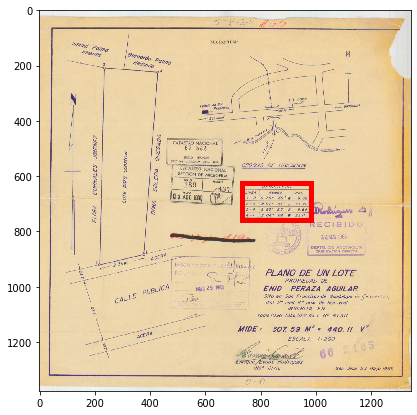

<Figure size 2160x2160 with 0 Axes>

id: 500 
Dataset: parte7 
top: 623 
left: 733 
height: 136 
width: 248 
ancho: 1377 
alto: 1377 
y1: 0.452432825 
x1: 0.53231663 
y2: 0.09876543199999999 
x2: 0.18010167 


In [25]:
## Muestra de imagen con su bbox
displayOne(500)

In [3]:
# load numpy array from npy file
from numpy import load
# load array
trX = load('img_values.npy')
trName = load('names.npy')
trSize = load('sizes.npy')


Carga en memoria de imagenes en crudo

*Si en caso no se tienen guardados las imagenes ya procesadas*

In [3]:
def read_img(path, shape):
    img = Image.open(r"../train_img/derimg/" + path)
    img_size = img.size
    img = img.resize(shape, Image.ANTIALIAS)
    img = np.asarray(img)
    return img, img_size

trX = []
trName = []
trSize = []
cont = 0
for file in os.listdir(r"../train_img/derimg"):
    cont +=1
    print('Procesando: {};  \r'.format(cont), end="")
    #filename = os.path.basename(file_n)
    trName.append(file)
    img, img_size = read_img(file, (224, 224))
    trX.append(img)
    trSize.append(img_size)
len(trX)

2048

In [4]:
# Se transforman a np array
trX = np.array(trX, dtype=np.uint8)
trX = trX/255.
trX.shape

(2048, 224, 224, 3)

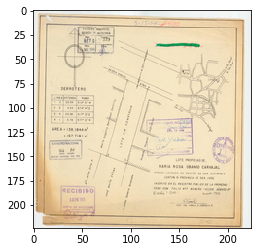

In [5]:
# muestra de imagen
plt.imshow(trX[110])

In [6]:
trX[110][100][0:10]

array([[0.93333333, 0.94117647, 0.9372549 ],
       [0.92156863, 0.92941176, 0.90980392],
       [0.9254902 , 0.9372549 , 0.93333333],
       [0.90980392, 0.87058824, 0.80784314],
       [0.90196078, 0.78823529, 0.61176471],
       [0.70196078, 0.61960784, 0.51372549],
       [0.9372549 , 0.84705882, 0.6745098 ],
       [0.94901961, 0.86666667, 0.70980392],
       [0.94901961, 0.86666667, 0.71764706],
       [0.94509804, 0.8745098 , 0.7254902 ]])

In [51]:
# Guardar carga de imagenes
from numpy import asarray
from numpy import save
# save to npy file
save('img_values.npy', trX)
save('names.npy', trName)
save('sizes.npy', trSize)


In [7]:
#Muesta de datos

trX[20:23,20:23,1]

array([[[0.91372549, 0.92941176, 0.9254902 ],
        [0.92156863, 0.92941176, 0.92941176],
        [0.92156863, 0.93333333, 0.92941176]],

       [[0.8745098 , 0.8745098 , 0.84705882],
        [0.85490196, 0.85490196, 0.81960784],
        [0.87058824, 0.8745098 , 0.83529412]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]]])

In [8]:
trName[0:10]

['100000011971.jpeg',
 '100000011973.jpeg',
 '100000021966.jpeg',
 '100000021968.jpeg',
 '100000021969.jpeg',
 '100000021971.jpeg',
 '100000021977.jpeg',
 '100000031968.jpeg',
 '100000031971.jpeg',
 '100000041977.jpeg']

Ordenar valores X con los valores Y

In [5]:
yTrain = []
for item in trName:
    fila = labels.loc[labels['idn'] == item]
    t = fila.values[0]
    yTrain.append([t[9],t[10],t[11],t[12]])
yTrain = np.array(yTrain)
yTrain[0:10]

array([[0.07460545, 0.42611191, 0.09397417, 0.19583931],
       [0.09025641, 0.83282051, 0.31692308, 0.2625641 ],
       [0.07872175, 0.36944661, 0.1441933 , 0.20654716],
       [0.26199262, 0.39621771, 0.10055351, 0.18588561],
       [0.33304348, 0.88956522, 0.1773913 , 0.22608696],
       [0.04385965, 1.08089669, 0.11500975, 0.2582846 ],
       [0.8184699 , 0.14440923, 0.10774106, 0.12947035],
       [0.06774809, 1.05343512, 0.11068702, 0.24713741],
       [0.02931596, 1.18892508, 0.10162866, 0.1732899 ],
       [0.70700637, 0.14194723, 0.16014559, 0.24021838]])

In [6]:
# Fucniones adicionales
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

checkpoint_path = 'cnn.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

save_prog = ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only =True,
    period=5
)

## VGG16

In [7]:
vgg16 = Sequential(name='vgg16')

# Block1
vgg16.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same', name='block1_conv1')) 
vgg16.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv2')) 
vgg16.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# Block 2
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')) 
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

# Classification block
vgg16.add(Flatten(name='flatten'))
vgg16.add(Dense(4096, activation='relu', name='fc1'))
vgg16.add(Dense(4096, activation='relu', name='fc2'))
vgg16.add(Dense(4, activation='softmax', name='predictions'))

    

In [8]:
#opt = optimizers.Adam(learning_rate=0.0005,amsgrad=True)
vgg16.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [9]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168

In [10]:
trX[0:10].shape, yTrain.shape

((10, 224, 224, 3), (2048, 4))

In [11]:
resultado = vgg16.fit(trX, yTrain,
                batch_size=16,
                validation_split=0.2,
                epochs=5,
                #shuffle=True,
                verbose=1, callbacks=[save_prog])

Train on 1638 samples, validate on 410 samples
Epoch 1/5
1638/1638 [==============================] - 70s 43ms/step - loss: 0.1018 - accuracy: 0.7875 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 2/5
1638/1638 [==============================] - 60s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 3/5
1638/1638 [==============================] - 60s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 4/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 5/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951

Epoch 00005: saving model to cnn.ckpt


### Visualizaciones Intermedias

In [12]:
def verIntermedias(modelo, visualizaciones=5, filtro = 2, imagenes =[0,1,2]):
    # definicion del plot
    f, ax = plt.subplots(len(imagenes),visualizaciones, figsize=(20, 8))

    # extraccion de las capas de activacion
    layer_outputs = [layer.output for layer in modelo.layers]
    activation_model = keras.models.Model(inputs=modelo.input,outputs=layer_outputs)

    # Visualizacion de las capas, varia segun la cantidad de parametros y filtro enviado
    for idx,i in enumerate(imagenes):
        ax[idx,0].imshow((trX[i]))
        ax[idx,0].imshow((trX[i]))
        ax[idx,0].imshow((trX[i]))

    for x in range(0,visualizaciones-1): # use first layers of the model: conv1,pool1,conv2,pool2
        for idx,i in enumerate(imagenes):
            f1 = activation_model.predict(trX[i].reshape(1, 224, 224, 3))[x]
            ax[idx,x+1].imshow(f1[0, : , :, filtro])
            ax[idx,x+1].grid(False)

    plt.show()

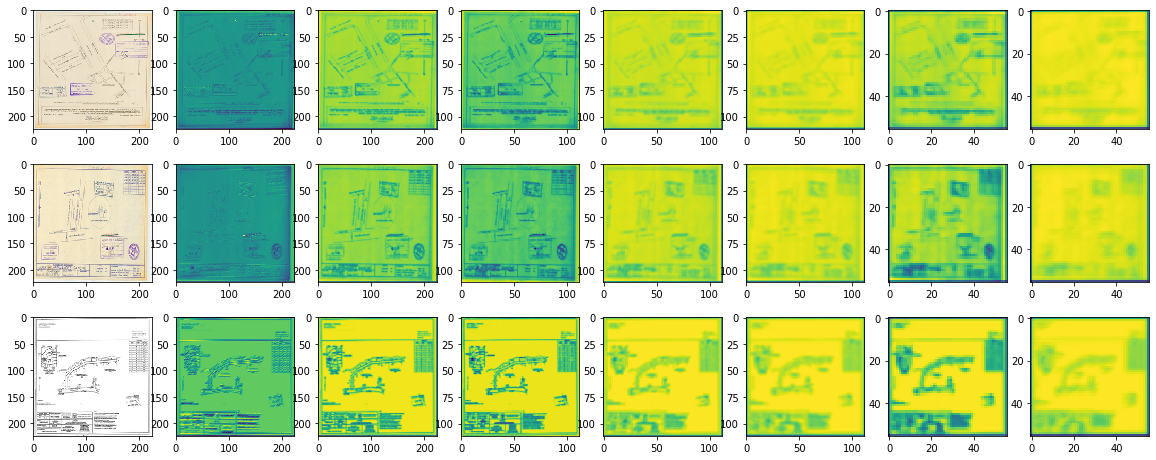

In [14]:
verIntermedias(vgg16, visualizaciones=8, filtro = 16, imagenes =[0,500,1000])

#### Utilizando el modelo preentrenado de VGG16

In [6]:
from keras.applications import VGG16

In [7]:
carga = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
carga.trainable = False

In [8]:
newModel = carga.output
newModel = Dropout(0.5,name='dropout05')(newModel)
newModel = Flatten(name='flatten')(newModel)
newModel = Dense(4096, activation='relu', name='fc1')(newModel)
newModel = Dropout(0.2)(newModel)
newModel = Dense(4096, activation='relu', name='fc2')(newModel)
newModel = Dense(4, activation='softmax', name='predictions')(newModel)
modelFvgg = keras.Model(carga.input, newModel)


In [9]:
modelFvgg.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [10]:
resultado2 = modelFvgg.fit(trX, yTrain,
                batch_size=16,
                validation_split=0.2,
                epochs=5,
                verbose=1)

Train on 1638 samples, validate on 410 samples
Epoch 1/5
1638/1638 [==============================] - 71s 43ms/step - loss: 0.1025 - accuracy: 0.8034 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 2/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 3/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 4/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 5/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951


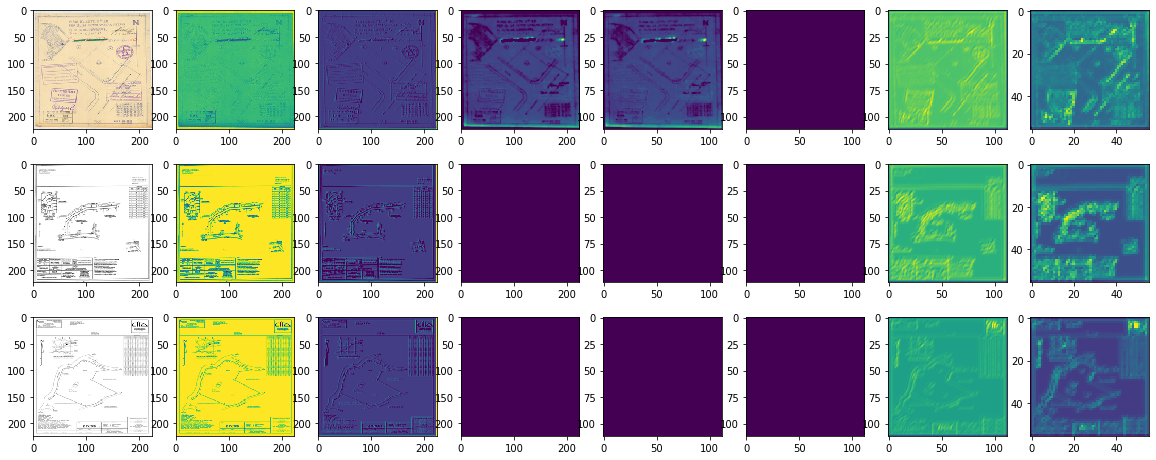

In [11]:
f, axarr = plt.subplots(3,8, figsize=(20, 8))
FIRST_IMAGE=100
SECOND_IMAGE=1000
THIRD_IMAGE=2000
FILTER_NUMBER = 2 # every conv layer has many filters, this selects which one to visualize

layer_outputs = [layer.output for layer in modelFvgg.layers]
activation_model = keras.models.Model(inputs=modelFvgg.input,outputs=layer_outputs)


axarr[0,0].imshow((trX[FIRST_IMAGE]))
axarr[1,0].imshow((trX[SECOND_IMAGE]))
axarr[2,0].imshow((trX[THIRD_IMAGE]))

for x in range(0,7): # use first layers of the model: conv1,pool1,conv2,pool2
    f1 = activation_model.predict(trX[FIRST_IMAGE].reshape(1, 224, 224, 3))[x]
    axarr[0,x+1].imshow(f1[0, : , :, FILTER_NUMBER])
    axarr[0,x+1].grid(False)
    f2 = activation_model.predict(trX[SECOND_IMAGE].reshape(1, 224, 224, 3))[x]
    axarr[1,x+1].imshow(f2[0, : , :, FILTER_NUMBER])
    axarr[1,x+1].grid(False)
    f3 = activation_model.predict(trX[THIRD_IMAGE].reshape(1, 224, 224, 3))[x]
    axarr[2,x+1].imshow(f3[0, : , :, FILTER_NUMBER])
    axarr[2,x+1].grid(False)

plt.show()

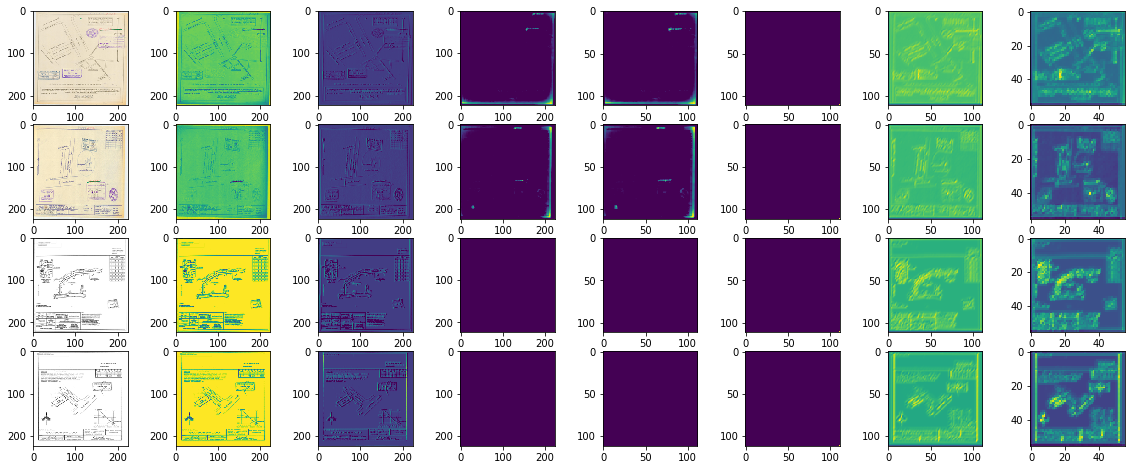

In [15]:
verIntermedias(modelFvgg, visualizaciones=8, filtro = 2, imagenes =[0,500,1000, 1500])

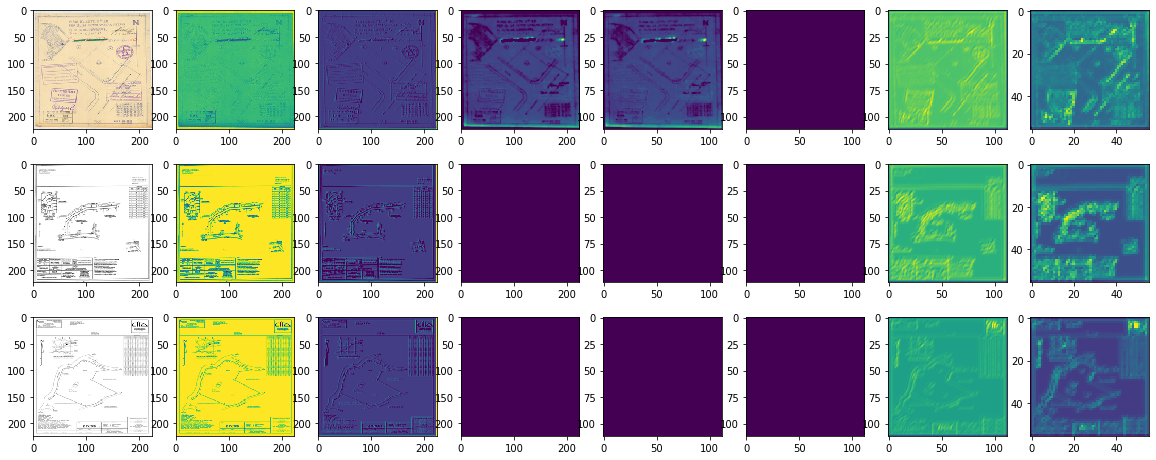

In [16]:
f, axarr = plt.subplots(3,8, figsize=(20, 8))
#selected_label = 9 # for analyzing images with the given label
#images_with_selected_lbl = np.where(test_labels == selected_label)[0]


FIRST_IMAGE=100
SECOND_IMAGE=1000
THIRD_IMAGE=2000
FILTER_NUMBER = 2 # every conv layer has many filters, this selects which one to visualize

# following code creates an "activation model", a model that takes an input and 
# generates a list of all layers actiations for another trained model
#from tensorflow.keras import models
layer_outputs = [layer.output for layer in modelFvgg.layers]
activation_model = keras.models.Model(inputs=modelFvgg.input,outputs=layer_outputs)

# visualization will have 1 row for every test image, and  4 columns:
# 1st column is the original image
# 2nd column is for the 1st convolution
# 3rd column is for the 1st pooling
# 4th column is for the 2nd convolution
# 5th column is for the 2nd pooling
axarr[0,0].imshow((trX[FIRST_IMAGE]))
axarr[1,0].imshow((trX[SECOND_IMAGE]))
axarr[2,0].imshow((trX[THIRD_IMAGE]))

for x in range(0,7): # use first layers of the model: conv1,pool1,conv2,pool2
    #print(x)
    # predict returns tensor of shape: number_images, height,width, number of filter
    f1 = activation_model.predict(trX[FIRST_IMAGE].reshape(1, 224, 224, 3))[x]
    axarr[0,x+1].imshow(f1[0, : , :, FILTER_NUMBER])
    axarr[0,x+1].grid(False)
    f2 = activation_model.predict(trX[SECOND_IMAGE].reshape(1, 224, 224, 3))[x]
    axarr[1,x+1].imshow(f2[0, : , :, FILTER_NUMBER])
    axarr[1,x+1].grid(False)
    f3 = activation_model.predict(trX[THIRD_IMAGE].reshape(1, 224, 224, 3))[x]
    axarr[2,x+1].imshow(f3[0, : , :, FILTER_NUMBER])
    axarr[2,x+1].grid(False)

plt.show()

In [18]:
modelFvgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

#### Utilizando vgg16 manual

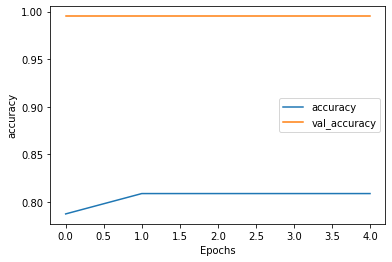

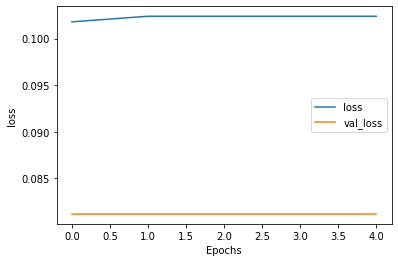

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(resultado, 'accuracy')
plot_graphs(resultado, 'loss')

#### Utilizando vgg16 preentrenado

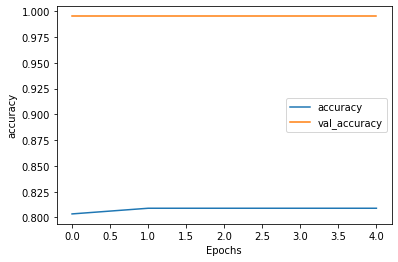

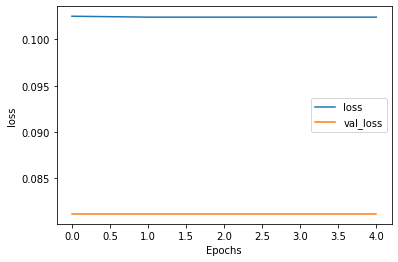

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(resultado2, 'accuracy')
plot_graphs(resultado2, 'loss')

# Conclusiones

El modelo creado desde cero y el modelo preentrenado convergen de forma similar, es debido al tipo de dato utilizado y se determinar que es necesario contar con mas datos para el entrenamiento.

Debido a que se selecciono un problema de localizacion, la documentacion disponible no es tan especifica como para problemas de clasificacion aunado con los datos reales y no un dataset probado presento desafios adicionales a este problema.

Para poder mejorar el rendimiento del modelo es necesario lidear con el problema de que algunas imagenes (planos) son grandes en sus escalas siendo la fuente imagenes escaneadas en tamaño A0, que al momento de reducir las imagenes para la entrada de la red se pierde presicion.

Los recursos necesarios de hardware se tornan significativos para este tipo de modelo ya que en mas de una ocacion se obtuvo un error por falta de memoria.  El equipo utilizado posee 16Gb de ram y una tarjeta nvidia GeoForce GTX de 4Gb.  Fue necesario reiniciar el kernel para poder realizar pruebas con diferentes parametros.

Debido a las limitaciones en el hardware los tamaños de batch de los datos fue de 16, ya que los parametros entrenables siendo 134 millones limitan otras comparaciones.  Ademas de limitar configuraciones complejas como parametros adicionesles al momento de realizar el entrenamiento.

Mas alla de los epochs definidos el modelo no sufre variaciones